In [1]:
import os
import json
import math
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available: 0


In [3]:
DATA_DIR = "food_data"  # folder with subfolders per class
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
VAL_SPLIT = 0.2
EPOCHS_WARMUP = 5     # train top layers only
EPOCHS_FINETUNE = 20  # unfreeze some backbone layers
TOP_K = 3             # report top-3 accuracy

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 0


In [4]:
class_names = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
num_classes = len(class_names)
print(f"Discovered {num_classes} classes.")

# Save class_names for Flask
with open("class_names.json", "w") as f:
    json.dump(class_names, f, indent=2)

Discovered 210 classes.


In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='categorical',         # one-hot labels
    class_names=class_names,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset='training'
)

Found 7297 files belonging to 210 classes.
Using 5838 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset='validation'
)

Found 7297 files belonging to 210 classes.
Using 1459 files for validation.


In [7]:
# Performance optimizations
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

# Strong augmentation pipeline
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1),
], name="augmentation")

In [8]:
preprocess_layer = layers.Lambda(preprocess_input, name="effnet_preprocess")

In [9]:
base = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    pooling="avg"  # global average pooling
)
base.trainable = False  # freeze backbone for warmup

inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation(inputs)
x = preprocess_layer(x)
x = base(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs, name="food_recognizer_effnetb0")
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step



Model: "food_recognizer_effnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ effnet_preprocess (Lambda)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 210)            │       107,730 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,813,173 (18.36 MB)

 Trainable params: 763,602 (2.91 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [10]:
class_counts = []
for cname in class_names:
    cdir = os.path.join(DATA_DIR, cname)
    count = sum(1 for fn in os.listdir(cdir) if fn.lower().endswith(('.png', '.jpg', '.jpeg')))
    class_counts.append(count)

total_images = sum(class_counts)
print("Total images:", total_images)
print("Min/Max per class:", min(class_counts), max(class_counts))

Total images: 7260
Min/Max per class: 12 75


In [11]:
from sklearn.utils.class_weight import compute_class_weight

labels_int = []
for i, cname in enumerate(class_names):
    labels_int += [i] * class_counts[i]

class_weight_values = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=np.array(labels_int)
)
class_weight = {i: w for i, w in enumerate(class_weight_values)}

print("Class weights:", class_weight)


Class weights: {0: np.float64(1.4404761904761905), 1: np.float64(1.3828571428571428), 2: np.float64(1.3828571428571428), 3: np.float64(1.3828571428571428), 4: np.float64(1.3828571428571428), 5: np.float64(1.3828571428571428), 6: np.float64(1.3828571428571428), 7: np.float64(1.3828571428571428), 8: np.float64(1.3828571428571428), 9: np.float64(1.3828571428571428), 10: np.float64(1.3828571428571428), 11: np.float64(1.3828571428571428), 12: np.float64(1.3828571428571428), 13: np.float64(1.3828571428571428), 14: np.float64(0.46095238095238095), 15: np.float64(1.3828571428571428), 16: np.float64(1.3828571428571428), 17: np.float64(1.3828571428571428), 18: np.float64(1.3828571428571428), 19: np.float64(1.3828571428571428), 20: np.float64(1.3828571428571428), 21: np.float64(1.3828571428571428), 22: np.float64(1.3828571428571428), 23: np.float64(1.3828571428571428), 24: np.float64(1.3828571428571428), 25: np.float64(1.3828571428571428), 26: np.float64(1.3828571428571428), 27: np.float64(1.3828

In [12]:
labels_int = []
for i, cname in enumerate(class_names):
    labels_int += [i] * class_counts[i]

if len(labels_int) > 0:
    class_weight_values = compute_class_weight(
        class_weight="balanced",
        classes=np.arange(num_classes),
        y=np.array(labels_int)
    )
    class_weight = {i: w for i, w in enumerate(class_weight_values)}
else:
    class_weight = None

print("Class weights computed:", bool(class_weight))


Class weights computed: True


In [13]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint("best_food_model.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
]

In [14]:
# Metrics: accuracy + top-k
metrics = [
    tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    TopKCategoricalAccuracy(k=TOP_K, name=f"top_{TOP_K}_accuracy"),
]

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="categorical_crossentropy",
              metrics=metrics)

history_warmup = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_WARMUP,
    class_weight=class_weight,
    callbacks=callbacks
)

Epoch 1/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.0428 - loss: 5.1568 - top_3_accuracy: 0.0953
Epoch 1: val_accuracy improved from None to 0.29609, saving model to best_food_model.h5


183/183 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.0853 - loss: 4.7295 - top_3_accuracy: 0.1799 - val_accuracy: 0.2961 - val_loss: 3.1969 - val_top_3_accuracy: 0.4880 - learning_rate: 0.0010
Epoch 2/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 749ms/step - accuracy: 0.2487 - loss: 3.2583 - top_3_accuracy: 0.4358
Epoch 2: val_accuracy improved from 0.29609 to 0.41878, saving model to best_food_model.h5


183/183 ━━━━━━━━━━━━━━━━━━━━ 164s 898ms/step - accuracy: 0.2669 - loss: 3.1305 - top_3_accuracy: 0.4570 - val_accuracy: 0.4188 - val_loss: 2.3325 - val_top_3_accuracy: 0.6361 - learning_rate: 0.0010
Epoch 3/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 726ms/step - accuracy: 0.3677 - loss: 2.5060 - top_3_accuracy: 0.5778
Epoch 3: val_accuracy improved from 0.41878 to 0.46059, saving model to best_food_model.h5


183/183 ━━━━━━━━━━━━━━━━━━━━ 160s 874ms/step - accuracy: 0.3770 - loss: 2.4633 - top_3_accuracy: 0.5874 - val_accuracy: 0.4606 - val_loss: 2.0353 - val_top_3_accuracy: 0.6840 - learning_rate: 0.0010
Epoch 4/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 741ms/step - accuracy: 0.4350 - loss: 2.1282 - top_3_accuracy: 0.6616
Epoch 4: val_accuracy improved from 0.46059 to 0.49212, saving model to best_food_model.h5


183/183 ━━━━━━━━━━━━━━━━━━━━ 162s 888ms/step - accuracy: 0.4382 - loss: 2.1133 - top_3_accuracy: 0.6598 - val_accuracy: 0.4921 - val_loss: 1.8920 - val_top_3_accuracy: 0.7142 - learning_rate: 0.0010
Epoch 5/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.4777 - loss: 1.8689 - top_3_accuracy: 0.7118
Epoch 5: val_accuracy improved from 0.49212 to 0.51405, saving model to best_food_model.h5


183/183 ━━━━━━━━━━━━━━━━━━━━ 180s 983ms/step - accuracy: 0.4848 - loss: 1.8718 - top_3_accuracy: 0.7074 - val_accuracy: 0.5141 - val_loss: 1.7834 - val_top_3_accuracy: 0.7354 - learning_rate: 0.0010


In [16]:
for layer in base.layers[-60:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),  # lower LR for fine-tuning
              loss="categorical_crossentropy",
              metrics=metrics)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FINETUNE,
    class_weight=class_weight,
    callbacks=callbacks
)

Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5437 - loss: 1.5414 - top_3_accuracy: 0.7625
Epoch 1: val_accuracy improved from 0.51405 to 0.57300, saving model to best_food_model.h5


183/183 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.5654 - loss: 1.4445 - top_3_accuracy: 0.7818 - val_accuracy: 0.5730 - val_loss: 1.5539 - val_top_3_accuracy: 0.7903 - learning_rate: 1.0000e-04
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6238 - loss: 1.2011 - top_3_accuracy: 0.8373
Epoch 2: val_accuracy improved from 0.57300 to 0.59150, saving model to best_food_model.h5


183/183 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.6384 - loss: 1.1913 - top_3_accuracy: 0.8398 - val_accuracy: 0.5915 - val_loss: 1.4894 - val_top_3_accuracy: 0.7882 - learning_rate: 1.0000e-04
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 891ms/step - accuracy: 0.6459 - loss: 1.1417 - top_3_accuracy: 0.8494
Epoch 3: val_accuracy improved from 0.59150 to 0.61275, saving model to best_food_model.h5


183/183 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.6531 - loss: 1.1162 - top_3_accuracy: 0.8511 - val_accuracy: 0.6127 - val_loss: 1.4297 - val_top_3_accuracy: 0.8088 - learning_rate: 1.0000e-04
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6747 - loss: 1.0423 - top_3_accuracy: 0.8782
Epoch 4: val_accuracy did not improve from 0.61275
183/183 ━━━━━━━━━━━━━━━━━━━━ 1809s 10s/step - accuracy: 0.6742 - loss: 1.0429 - top_3_accuracy: 0.8731 - val_accuracy: 0.6045 - val_loss: 1.4079 - val_top_3_accuracy: 0.8122 - learning_rate: 1.0000e-04
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - accuracy: 0.7000 - loss: 0.9182 - top_3_accuracy: 0.8966
Epoch 5: val_accuracy improved from 0.61275 to 0.61686, saving model to best_food_model.h5


183/183 ━━━━━━━━━━━━━━━━━━━━ 179s 978ms/step - accuracy: 0.6978 - loss: 0.9219 - top_3_accuracy: 0.8905 - val_accuracy: 0.6169 - val_loss: 1.3867 - val_top_3_accuracy: 0.8211 - learning_rate: 1.0000e-04
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 832ms/step - accuracy: 0.7242 - loss: 0.8709 - top_3_accuracy: 0.8994
Epoch 6: val_accuracy did not improve from 0.61686
183/183 ━━━━━━━━━━━━━━━━━━━━ 176s 961ms/step - accuracy: 0.7186 - loss: 0.8738 - top_3_accuracy: 0.8976 - val_accuracy: 0.6080 - val_loss: 1.3901 - val_top_3_accuracy: 0.8259 - learning_rate: 1.0000e-04
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - accuracy: 0.7283 - loss: 0.8234 - top_3_accuracy: 0.9176
Epoch 7: val_accuracy improved from 0.61686 to 0.63125, saving model to best_food_model.h5


183/183 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.7319 - loss: 0.8150 - top_3_accuracy: 0.9123 - val_accuracy: 0.6313 - val_loss: 1.3536 - val_top_3_accuracy: 0.8232 - learning_rate: 1.0000e-04
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.7434 - loss: 0.7684 - top_3_accuracy: 0.9107
Epoch 8: val_accuracy improved from 0.63125 to 0.63194, saving model to best_food_model.h5


183/183 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.7477 - loss: 0.7642 - top_3_accuracy: 0.9132 - val_accuracy: 0.6319 - val_loss: 1.3477 - val_top_3_accuracy: 0.8321 - learning_rate: 1.0000e-04
Epoch 9/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.7662 - loss: 0.6969 - top_3_accuracy: 0.9292
Epoch 9: val_accuracy did not improve from 0.63194
183/183 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.7653 - loss: 0.7065 - top_3_accuracy: 0.9246 - val_accuracy: 0.6271 - val_loss: 1.3514 - val_top_3_accuracy: 0.8293 - learning_rate: 1.0000e-04
Epoch 10/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.7663 - loss: 0.6697 - top_3_accuracy: 0.9308 
Epoch 10: val_accuracy improved from 0.63194 to 0.63742, saving model to best_food_model.h5


183/183 ━━━━━━━━━━━━━━━━━━━━ 2844s 16s/step - accuracy: 0.7754 - loss: 0.6586 - top_3_accuracy: 0.9323 - val_accuracy: 0.6374 - val_loss: 1.3561 - val_top_3_accuracy: 0.8334 - learning_rate: 1.0000e-04
Epoch 11/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.7861 - loss: 0.6363 - top_3_accuracy: 0.9365
Epoch 11: val_accuracy improved from 0.63742 to 0.65182, saving model to best_food_model.h5


183/183 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.7857 - loss: 0.6325 - top_3_accuracy: 0.9337 - val_accuracy: 0.6518 - val_loss: 1.3160 - val_top_3_accuracy: 0.8396 - learning_rate: 1.0000e-04
Epoch 12/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.7969 - loss: 0.5842 - top_3_accuracy: 0.9436
Epoch 12: val_accuracy did not improve from 0.65182
183/183 ━━━━━━━━━━━━━━━━━━━━ 172s 940ms/step - accuracy: 0.7986 - loss: 0.5820 - top_3_accuracy: 0.9433 - val_accuracy: 0.6429 - val_loss: 1.3381 - val_top_3_accuracy: 0.8328 - learning_rate: 1.0000e-04
Epoch 13/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 853ms/step - accuracy: 0.8063 - loss: 0.5635 - top_3_accuracy: 0.9480
Epoch 13: val_accuracy did not improve from 0.65182
183/183 ━━━━━━━━━━━━━━━━━━━━ 181s 991ms/step - accuracy: 0.8087 - loss: 0.5521 - top_3_accuracy: 0.9491 - val_accuracy: 0.6518 - val_loss: 1.3335 - val_top_3_accuracy: 0.8403 - learning_rate: 1.0000e-04
Epoch 14/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accur

183/183 ━━━━━━━━━━━━━━━━━━━━ 169s 923ms/step - accuracy: 0.8100 - loss: 0.5595 - top_3_accuracy: 0.9472 - val_accuracy: 0.6580 - val_loss: 1.3203 - val_top_3_accuracy: 0.8417 - learning_rate: 1.0000e-04
Epoch 15/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.8148 - loss: 0.4986 - top_3_accuracy: 0.9582
Epoch 15: val_accuracy did not improve from 0.65798
183/183 ━━━━━━━━━━━━━━━━━━━━ 167s 913ms/step - accuracy: 0.8224 - loss: 0.4959 - top_3_accuracy: 0.9587 - val_accuracy: 0.6498 - val_loss: 1.3281 - val_top_3_accuracy: 0.8513 - learning_rate: 5.0000e-05
Epoch 16/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8424 - loss: 0.4484 - top_3_accuracy: 0.9663
Epoch 16: val_accuracy did not improve from 0.65798
183/183 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.8452 - loss: 0.4464 - top_3_accuracy: 0.9637 - val_accuracy: 0.6450 - val_loss: 1.3448 - val_top_3_accuracy: 0.8417 - learning_rate: 5.0000e-05


In [17]:
y_true = []
y_pred = []

for batch_imgs, batch_labels in val_ds:
    preds = model.predict(batch_imgs, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(batch_labels.numpy(), axis=1))

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))


Classification Report:

                               precision    recall  f1-score   support

                Arugula_salad      1.000     0.800     0.889         5
             Barbecue_chicken      0.000     0.000     0.000         3
           Beaf Peanut butter      0.500     0.667     0.571         3
         Beaf stake sandwitch      0.500     0.500     0.500         2
                Beef Bashamel      0.750     0.300     0.429        10
                   Beef Kufta      1.000     0.833     0.909         6
                Beef bashamil      0.143     0.500     0.222         2
                    Beef roll      1.000     0.200     0.333         5
                  Beef syraih      0.500     0.200     0.286         5
 Beef_fahita-removebg-preview      0.833     0.714     0.769         7
                     Brownies      0.500     0.500     0.500         2
              Buffalo_chicken      0.333     0.500     0.400         2
               BurgaRice_Beef      0.500     0.250 

C:\Users\Muneeb\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Muneeb\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Muneeb\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

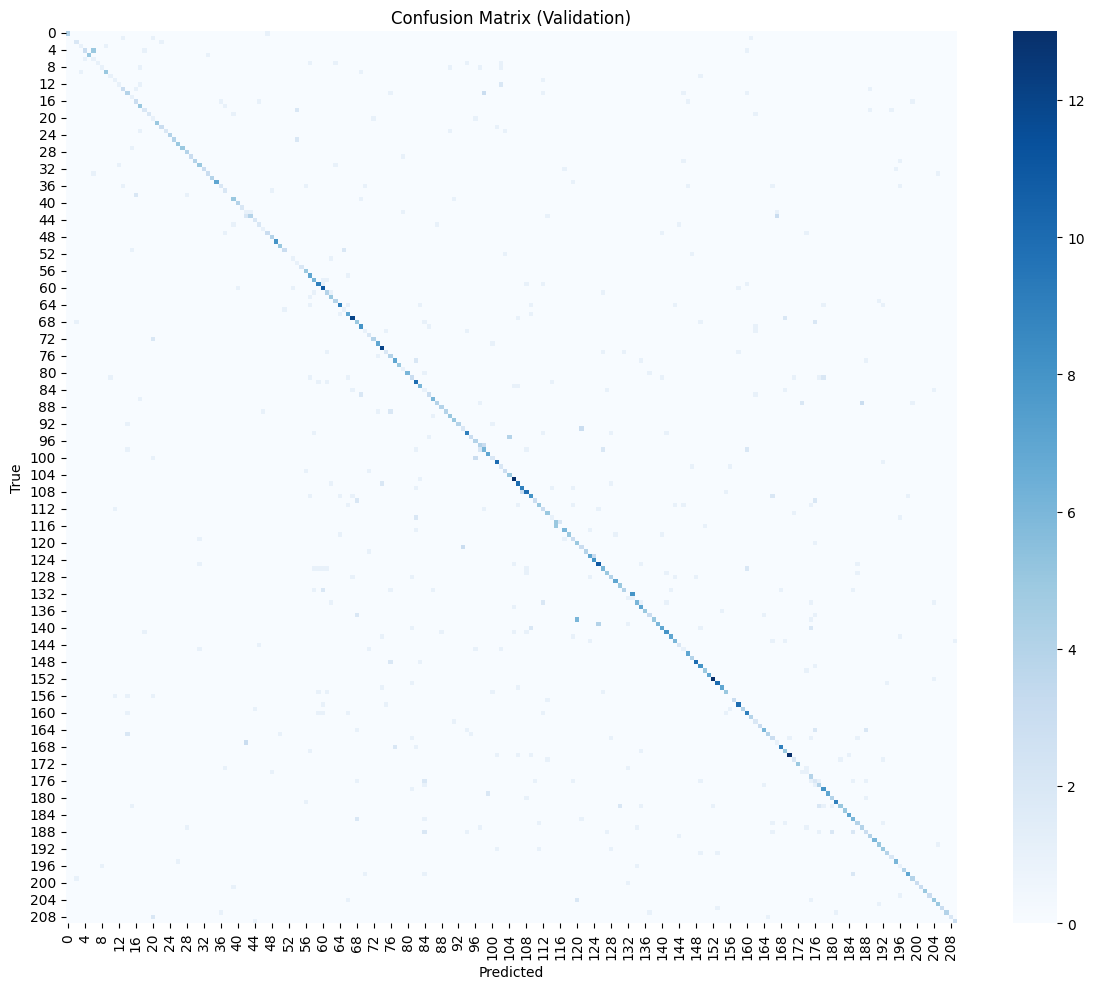

In [18]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues", cbar=True)
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [19]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'                      
)


In [19]:
model.save("dish_model.h5")
print("Saved dish_model.h5 and best_food_model.h5")

Saved dish_model.h5 and best_food_model.h5


In [3]:
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input

model = load_model("dish_model.h5", custom_objects={"preprocess_input": preprocess_input})


In [4]:
model.save("dish_model.keras")
